In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import pickle
from siamese import SiameseRNN
from scipy import spatial
import nltk
import difflib
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

%matplotlib inline



In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
max_length = 15

# tensorflow model
checkpoint_path = 'checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400'

model_parameters = {}
model_parameters['rnn_type'] = 'lstm'
model_parameters['dropout'] = 0
model_parameters['padding'] = 'right'
model_parameters['sequence_length'] = 15
model_parameters['opt'] = 'adam'
model_parameters['learning_rate'] = 0.01
model_parameters['max_steps'] = 80000
model_parameters['n_input'] = 300
model_parameters['n_hidden'] = 50
model_parameters['rnn_layers'] = 1
model_parameters['batch_size'] = 128
model_parameters['distance_threshold'] = 0.5
model_parameters['loss'] = 'manhattan'

#Create tensorflow model and train
print('Create model...')
model = SiameseRNN(model_parameters)

Create model...


C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Feature Engineering

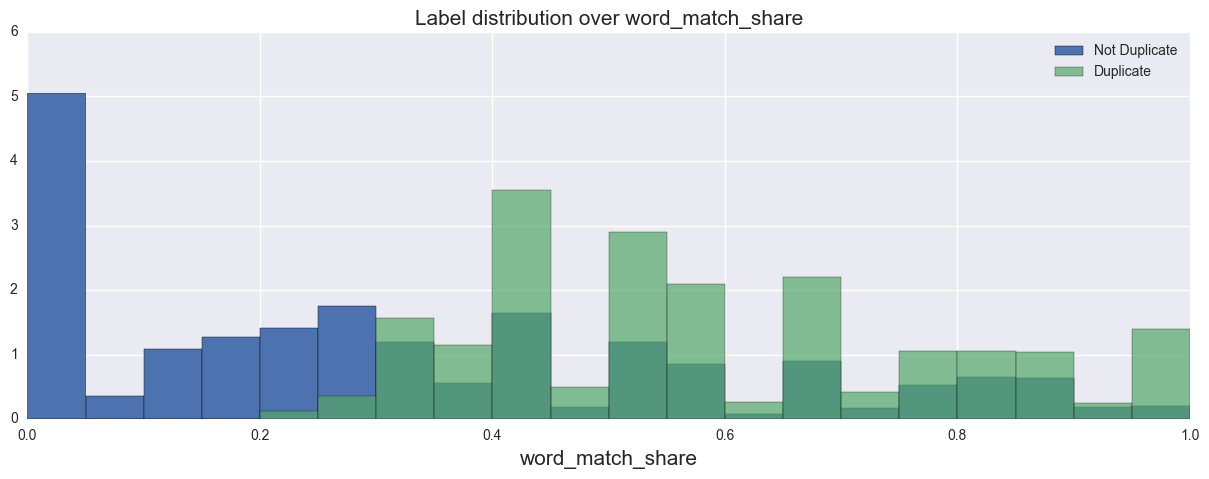

In [4]:
# Word match

from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

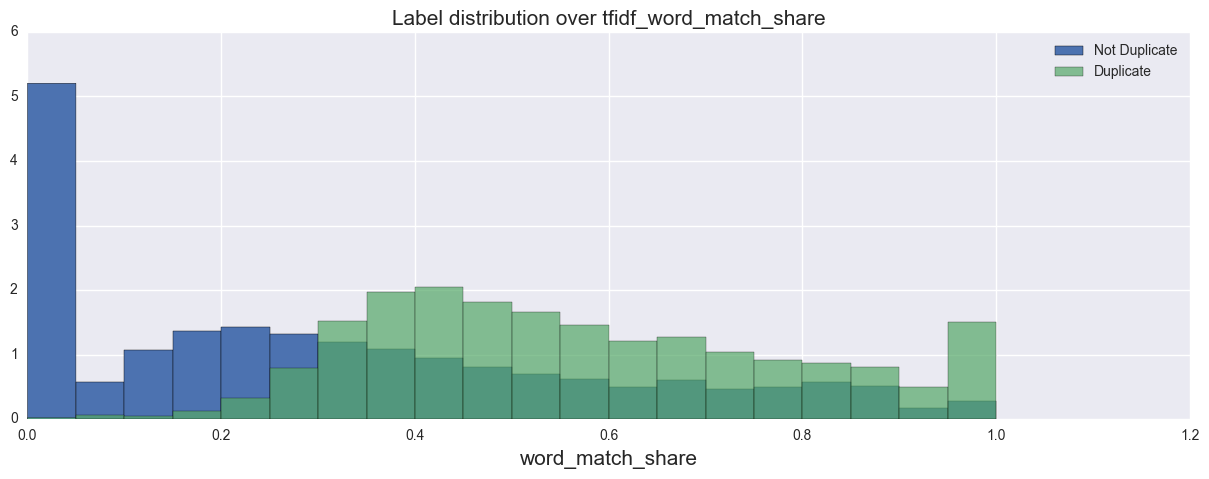

In [5]:
# tf-idf

train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [6]:
# Here we should add the similarity and/or distance
def obtain_similarities(max_length, checkpoint_path, model_parameters, num_total_files, set_to_obtain):

    
    
    if set_to_obtain == 'train':
        num_samples = len(df_train)
    elif set_to_obtain == 'test':
        num_samples = len(df_test)
    similarities = np.zeros((num_samples), np.float32)
    
    idx_similarities = 0
    for i in range(num_total_files):
        # Load training pickles
        with open('pickles/X_' + set_to_obtain + '_1_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
            X_train_1 = pickle.load(handle)
        with open('pickles/X_' + set_to_obtain + '_2_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
            X_train_2 = pickle.load(handle) 
        # Compute similarities
        similarities_batch, h1, h2 = model.get_distances_and_hidden(X_train_1, X_train_2, np.zeros(len(X_train_1), np.int8), checkpoint_path)
        similarities[idx_similarities:(idx_similarities + len(similarities_batch))] = similarities_batch
        idx_similarities += len(similarities_batch)
        print(i)

    return similarities

def obtain_similarities_and_other_features(max_length, checkpoint_path, model_parameters, num_total_files, set_to_obtain, size_hidden):

    if set_to_obtain == 'train':
        num_samples = len(df_train)
    elif set_to_obtain == 'test':
        num_samples = len(df_test)
    
    similarities = np.zeros((num_samples), np.float32)
    difference_hidden = np.zeros((num_samples, size_hidden), np.float32)
    multwise_hidden = np.zeros((num_samples, size_hidden), np.float32)
    
    idx = 0
    for i in range(num_total_files):
        # Load training pickles
        with open('pickles/X_' + set_to_obtain + '_1_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
            X_train_1 = pickle.load(handle)
        with open('pickles/X_' + set_to_obtain + '_2_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
            X_train_2 = pickle.load(handle) 
        # Compute similarities
        similarities_batch, h1, h2 = model.get_distances_and_hidden(X_train_1, X_train_2, np.zeros(len(X_train_1), np.int8), checkpoint_path)
        similarities[idx:(idx + len(similarities_batch))] = similarities_batch
        difference_hidden[idx:(idx + len(similarities_batch))] = np.abs(h1 - h2)
        multwise_hidden[idx:(idx + len(similarities_batch))] = h1 * h2
        idx += len(similarities_batch)

    return similarities, difference_hidden, multwise_hidden

In [7]:
#Features from this script: https://www.kaggle.com/the1owl/quora-question-pairs/matching-que-for-quora-end-to-end-0-33719-pb

def get_noun_match(df):
    print('Computing noun match feature...')
    df['question1_nouns'] = df.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df['question2_nouns'] = df.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df['z_noun_match'] = df.apply(lambda r: sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1)  #takes long
    return df['z_noun_match'].values

def get_character_len(df): #Include also the caracther length difference?
    print('Computing character len feature...')
    df['z_len1'] = df.question1.map(lambda x: len(str(x)))
    df['z_len2'] = df.question2.map(lambda x: len(str(x)))
    df['z_len_diff'] = np.abs(df['z_len1'].values - df['z_len2'].values)
    return df['z_len1'].values, df['z_len2'].values, df['z_len_diff']


def get_word_len(df): #Include also the word length difference?
    print('Computing word length feature...')
    df['z_word_len1'] = df.question1.map(lambda x: len(str(x).split()))
    df['z_word_len2'] = df.question2.map(lambda x: len(str(x).split()))
    df['z_word_len_diff'] = np.abs(df['z_word_len1'].values - df['z_word_len2'].values)
    return df['z_word_len1'].values, df['z_word_len2'].values, df['z_word_len_diff'].values


def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()
    
def get_match_ratio(df):
    print('Computing match ration feature...')
    df['z_match_ratio'] = df.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)  #takes long
    return df['z_match_ratio'].values

def get_tfidf_aux(df, tfidf):
    
    df['z_tfidf_sum1'] = df.question1.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df['z_tfidf_sum2'] = df.question2.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df['z_tfidf_mean1'] = df.question1.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    df['z_tfidf_mean2'] = df.question2.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    df['z_tfidf_len1'] = df.question1.map(lambda x: len(tfidf.transform([str(x)]).data))
    df['z_tfidf_len2'] = df.question2.map(lambda x: len(tfidf.transform([str(x)]).data))
    
    #z1 = tfidf.transform(df.question1)
    #z2 = tfidf.transform(df.question2)

    #df['z_tfidf_sum1'] = z1.sum(axis = 1)
    #df['z_tfidf_sum2'] = z2.sum(axis = 1)
    #df['z_tfidf_len1'] = z1.sign().sum(axis = 1)
    #df['z_tfidf_len2'] = z2.sign().sum(axis = 1)
    #df['z_tfidf_mean1'] = df['z_tfidf_sum1']/df['z_tfidf_len1']
    #df['z_tfidf_mean2'] = df['z_tfidf_sum2']/df['z_tfidf_len2']
    
    return df['z_tfidf_sum1'], df['z_tfidf_sum2'], df['z_tfidf_len1'], df['z_tfidf_len2'], df['z_tfidf_mean1'], df['z_tfidf_mean2']


In [18]:
# More features

        
def same_start_word(row):
    try:
        if not row['question1'] or not row['question2']:
            return np.nan
        if len(row['question1']) == 0:
            return 0
        if len(row['question2']) == 0:
            return 0
        return int(row['question1'][0] == row['question2'][0])
    except:
        return 0

train_word_same_start = df_train.apply(same_start_word, axis=1, raw=True)

def char_ratio(row):
    try:
        l1 = len(''.join(row['question1'])) 
        l2 = len(''.join(row['question2']))
        if l2 == 0:
            return np.nan
        if l2 > l1:
            return l2 / l1
        else:
            return l1 / l2
    except:
        return 0
    
train_word_char_ratio = df_train.apply(char_ratio, axis=1, raw=True)

In [20]:
num_total_files = 9
set_to_obtain = 'train'
similarities, difference_hidden, multwise_hidden = obtain_similarities_and_other_features(max_length, checkpoint_path, model_parameters, num_total_files, set_to_obtain, model_parameters['n_hidden'])



load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_b

In [30]:
# First we create our training data

features = ['word_match', 'tfidf_word_match', 'similarity']
features = ['word_match', 'tfidf_word_match', 'similarity', 'character_len', 'word_len', 
            'match_ratio', 'difference_hidden', 'multwise_hidden']
#features = ['word_match', 'tfidf_word_match', 'similarity', 'difference_hidden_', 'multwise_hidden']
#features = ['word_match', 'tfidf_word_match', 'similarity', 'difference_hidden_', 'multwise_hidden', 'noun_match, 'character_len', 'word_len', 'match_ratio', 'tfidf_aux']
#features = ['word_match', 'tfidf_word_match', 'noun_match', 'character_len', 'word_len', 'match_ratio', 'tfidf_aux']

x_train = pd.DataFrame()
if 'word_match' in features:
    x_train['word_match'] = train_word_match
if 'tfidf_word_match' in features:
    x_train['tfidf_word_match'] = tfidf_train_word_match

if 'noun_match' in features:
    x_train['noun_match'] = get_noun_match(df_train)
if 'character_len' in features:
    x_train['character_len_1'], x_train['character_len_2'], x_train['character_len_diff'] = get_character_len(df_train)
if 'word_len' in features:
    x_train['word_len_1'], x_train['word_len_2'], x_train['word_len_diff'] = get_word_len(df_train)
if 'match_ratio' in features:
    x_train['match_ratio'] = get_match_ratio(df_train)
if 'tfidf_aux' in features:
    x_train['z_tfidf_sum1'], x_train['z_tfidf_sum2'], x_train['z_tfidf_len1'], x_train['z_tfidf_len2'], x_train['z_tfidf_mean1'], x_train['z_tfidf_mean2'] = get_tfidf_aux(df_train)
if 'features_with_embeddings' in features:
    x_train['bow_sum1'], x_train['bow_sum2'], x_train['bow_mean1'], x_train['bow_mean2'], x_train['cosine_sim'], x_train['hamming'], x_train['pearson'] = get_features_with_embeddings(df_train)

if 'similarity' in features:
    x_train['similarity'] = similarities # test with and without this feature
    
#difference_hidden feature
if 'difference_hidden' in features:
    for i in range(difference_hidden.shape[1]):
        x_train['difference_hidden_' + str(i)] = difference_hidden[:,i]
    
#difference_hidden feature
if 'multwise_hidden' in features:
    for i in range(multwise_hidden.shape[1]):
        x_train['multwise_hidden' + str(i)] = multwise_hidden[:,i]

        
# Add fuzzy features
fuzzy_features = ['common_words', 'fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio',
               'fuzz_token_sort_ratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'fuzz_partial_token_sort_ratio' ]
df_features_train = pd.read_csv('features/train_features.csv', encoding='ISO-8859-1')
for c in df_features_train.columns:
    if c in fuzzy_features:
        print(c)
        x_train[c] = df_features_train[c]
        

# word2vec features
word2vec_features = ['wmd', 'norm_wmd', 'cosine_distance', 'cityblock_distance', 'jaccard_distance', 'canberra_distance'
                    'euclidean_distance', 'minkowski_distance', 'braycurtis_distance', 'skew_q1vec', 'skew_q2_vec', 
                    'kur_q1vec', 'kur_q2vec']
for c in df_features_train.columns:
    if c in word2vec_features:
        print(c)
        x_train[c] = df_features_train[c]
        
# magic features - intersect
x_train['q1_q2_intersect'] = df_train['q1_q2_intersect']

# magic features - frequency [['id','q1_hash','q2_hash','q1_freq','q2_freq']]
x_train['q1_freq'] = train_comb['q1_freq']
x_train['q2_freq'] = train_comb['q2_freq']
#x_train['q1_hash'] = train_comb['q1_hash']
#x_train['q2_hash'] = train_comb['q2_hash']

# More features
x_train['same_start'] = train_word_same_start
x_train['char_ration'] = train_word_char_ratio
    

y_train = df_train['is_duplicate'].values

Computing character len feature...
Computing word length feature...
Computing match ration feature...
common_words
fuzz_qratio
fuzz_WRatio
fuzz_partial_ratio
fuzz_partial_token_set_ratio
fuzz_partial_token_sort_ratio
fuzz_token_set_ratio
fuzz_token_sort_ratio
wmd
norm_wmd
cosine_distance
cityblock_distance
jaccard_distance
minkowski_distance
braycurtis_distance
skew_q1vec
kur_q1vec
kur_q2vec


In [10]:
df_features_train.columns

Index(['question1', 'question2', 'len_q1', 'len_q2', 'diff_len', 'len_char_q1',
       'len_char_q2', 'len_word_q1', 'len_word_q2', 'common_words',
       'fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio',
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'wmd', 'norm_wmd',
       'cosine_distance', 'cityblock_distance', 'jaccard_distance',
       'canberra_distance', 'euclidean_distance', 'minkowski_distance',
       'braycurtis_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
       'kur_q2vec'],
      dtype='object')

In [39]:
print(len(x_train))
print(len(difference_hidden))

404290
46


question1
question2
len_q1
len_q2
diff_len
len_char_q1
len_char_q2
len_word_q1
len_word_q2
common_words
fuzz_qratio
fuzz_WRatio
fuzz_partial_ratio
fuzz_partial_token_set_ratio
fuzz_partial_token_sort_ratio
fuzz_token_set_ratio
fuzz_token_sort_ratio
wmd
norm_wmd
cosine_distance
cityblock_distance
jaccard_distance
canberra_distance
euclidean_distance
minkowski_distance
braycurtis_distance
skew_q1vec
skew_q2vec
kur_q1vec
kur_q2vec


# Balance the data and train

In [31]:
#Balancing the data

pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [32]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

[0]	train-logloss:0.657143	valid-logloss:0.657279
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.429933	valid-logloss:0.431255
[20]	train-logloss:0.322958	valid-logloss:0.325074
[30]	train-logloss:0.266454	valid-logloss:0.269283
[40]	train-logloss:0.234617	valid-logloss:0.238035
[50]	train-logloss:0.215337	valid-logloss:0.219287
[60]	train-logloss:0.20366	valid-logloss:0.208111
[70]	train-logloss:0.19617	valid-logloss:0.201052
[80]	train-logloss:0.190869	valid-logloss:0.196167
[90]	train-logloss:0.187026	valid-logloss:0.19272
[100]	train-logloss:0.184172	valid-logloss:0.190249
[110]	train-logloss:0.181742	valid-logloss:0.188257
[120]	train-logloss:0.179589	valid-logloss:0.186564
[130]	train-logloss:0.17773	valid-logloss:0.185181
[140]	train-logloss:0.175875	valid-logloss:0.183926
[150]	train-logloss:0.17431	valid-logloss:0.18285
[160]	train-logloss:0.172885	valid

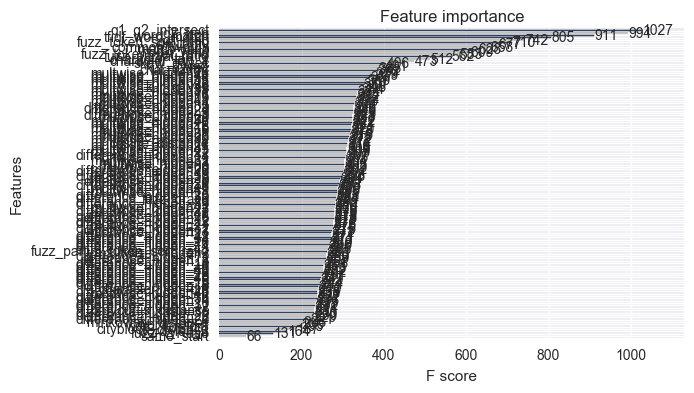

In [65]:


#Train XGBoost
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.05
params['max_depth'] = 7
params['min_child_weight'] = 3 # 5,6,7
params['gamma'] = 0.5 #0.3, 0.5
params['subsample'] = 0.5 #0.3, 0.5, 0.7
#params['colsample_bytree'] = 0.1 #0.3, 0.5, 0.7
#params['reg_alpha']:[1e-5, 1e-2, 0.1, 1, 100]


d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)

# Save model
bst.save_model('models/xgboost_m1.model')

xgb.plot_importance(bst)



In [ ]:
#Train XGBoost - Grid search
import xgboost as xgb

# Grid search

etas = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.5]
max_depths = [3, 5, 7, 9]


for eta in etas:
    for max_depth in max_depths:
        print('eta: ' + str(eta))
        print('max_depth: ' + str(max_depth))
        # Set our parameters for xgboost
        params = {}
        params['objective'] = 'binary:logistic'
        params['eval_metric'] = 'logloss'
        params['eta'] = eta
        params['max_depth'] = max_depth

        d_train = xgb.DMatrix(x_train, label=y_train)
        d_valid = xgb.DMatrix(x_valid, label=y_valid)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]

        bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)
        name_model = 'xgboost_' + str(eta) + '_' + str(max_depth)
        bst.save_model(name_model)

# Test - Create features and make predicitons

In [21]:
df_test = pd.read_csv('test.csv')
# Add fuzzy features
df_features_test = pd.read_csv('features/test_features.csv', encoding='ISO-8859-1')

In [62]:
import gc
gc.collect()

2040

In [66]:
import gc
gc.collect()
# Make predictions in chunks 

#bst = xgb.Booster({'nthread':4}) #init model
#bst.load_model("xgboost_m1.model") # load data

features = ['word_match', 'tfidf_word_match', 'similarity', 'difference_hidden', 'multwise_hidden']
#features = ['word_match', 'tfidf_word_match', 'similarity', 'character_len', 'word_len', 'match_ratio', 'difference_hidden', 'multwise_hidden']
features = ['word_match', 'tfidf_word_match', 'similarity', 'character_len', 'word_len', 'match_ratio', 'difference_hidden', 'multwise_hidden']

word_matches = df_test.apply(word_match_share, axis=1, raw=True)
tfidf_word_matches = df_test.apply(tfidf_word_match_share, axis=1, raw=True)
test_word_same_start = df_test.apply(same_start_word, axis=1, raw=True)
test_word_char_ratio = df_test.apply(char_ratio, axis=1, raw=True)
if 'noun_match' in features:
    noun_match = get_noun_match(df_test)
if 'character_len' in features:
    character_len_1, character_len_2, character_len_diff = get_character_len(df_test)
if 'word_len' in features:
    word_len_1, word_len_2, word_len_diff = get_word_len(df_test)
if 'match_ratio' in features:
    match_ratio = get_match_ratio(df_test)
if 'tfidf_aux' in features:
    tfidf_sum1, tfidf_sum2, tfidf_len1, tfidf_len2, tfidf_mean1, tfidf_mean2 = get_tfidf_aux(df_test)
if 'features_with_embeddings' in features:
    bow_sum1, bow_sum2, bow_mean1, bow_mean2, cosine_sim, hamming, pearson = get_features_with_embeddings(df_test)

    
test_ids = df_test['test_id'].values

num_test_files = 51
idx = 0
for i in range(num_test_files):
    print(i)
    # Load test pickles
    with open('pickles/X_test_1_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
        X_test_1 = pickle.load(handle)
    with open('pickles/X_test_2_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
        X_test_2 = pickle.load(handle) 
    
    
    # Create dataframe to predict this chunk
    x_test = pd.DataFrame()
    
    if 'word_match' in features:
        x_test['word_match'] = word_matches[idx:(idx + len(X_test_1))]
    if 'tfidf_word_match' in features:
        x_test['tfidf_word_match'] = tfidf_word_matches[idx:(idx + len(X_test_1))]
        
    
    
    if 'noun_match' in features:
        x_test['noun_match'] = noun_match[idx:(idx + len(X_test_1))]
    if 'character_len' in features:
        x_test['character_len_1'] = character_len_1[idx:(idx + len(X_test_1))]
        x_test['character_len_2'] = character_len_2[idx:(idx + len(X_test_1))]
        x_test['character_len_diff'] = character_len_diff[idx:(idx + len(X_test_1))]
    if 'word_len' in features:
        x_test['word_len_1'] = word_len_1[idx:(idx + len(X_test_1))]
        x_test['word_len_2'] = word_len_2[idx:(idx + len(X_test_1))]
        x_test['word_len_diff'] = word_len_diff[idx:(idx + len(X_test_1))]
    if 'match_ratio' in features:
        x_test['match_ratio'] = match_ratio[idx:(idx + len(X_test_1))]
    if 'tfidf_aux' in features:
        x_test['tfidf_sum1'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['tfidf_sum2'] = tfidf_sum2[idx:(idx + len(X_test_1))]
        x_test['tfidf_len1'] = tfidf_len1[idx:(idx + len(X_test_1))]
        x_test['tfidf_len2'] = tfidf_len2[idx:(idx + len(X_test_1))]
        x_test['tfidf_mean1'] = tfidf_mean1[idx:(idx + len(X_test_1))]
        x_test['tfidf_mean2'] = tfidf_mean2[idx:(idx + len(X_test_1))]
    if 'features_with_embeddings' in features:
        x_test['bow_sum1'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['bow_sum2'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['bow_mean1'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['bow_mean2'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['cosine_sim'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['hamming'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['pearson'] = tfidf_sum1[idx:(idx + len(X_test_1))]
    
    if 'similarity' in features:
        # Compute similarities
        similarities_batch, h1, h2 = model.get_distances_and_hidden(X_test_1, X_test_2, [], checkpoint_path)
        x_test['similarity'] = similarities_batch
    
    if 'difference_hidden' in features:
        for j in range(difference_hidden.shape[1]):
            difference_hidden = np.abs(h1 - h2)
            x_test['difference_hidden_' + str(j)] = difference_hidden[:,j]
    if 'multwise_hidden' in features:
        for j in range(difference_hidden.shape[1]):
            multwise_hidden = h1 * h2
            x_test['multwise_hidden' + str(j)] = multwise_hidden[:,j]
    
    # Add fuzzy features
    for c in df_features_test.columns:
        if c in fuzzy_features:
            #print(c)
            x_test[c] = df_features_test[c].values[idx:(idx + len(X_test_1))]
            
    #word2vec features
    for c in df_features_train.columns:
        if c in word2vec_features:
            #print(c)
            x_test[c] = df_features_test[c].values[idx:(idx + len(X_test_1))]
            
    # magic features
    x_test['q1_q2_intersect'] = df_test['q1_q2_intersect'].values[idx:(idx + len(X_test_1))]
    
    # magic features - frequency [['id','q1_hash','q2_hash','q1_freq','q2_freq']]
    x_test['q1_freq'] = test_comb['q1_freq'].values[idx:(idx + len(X_test_1))]
    x_test['q2_freq'] = test_comb['q2_freq'].values[idx:(idx + len(X_test_1))]
    #x_test['q1_hash'] = test_comb['q1_hash'].values[idx:(idx + len(X_test_1))]
    #x_test['q2_hash'] = test_comb['q2_hash'].values[idx:(idx + len(X_test_1))]
        
    x_test['same_start'] = test_word_same_start[idx:(idx + len(X_test_1))]
    x_test['char_ration'] = test_word_char_ratio[idx:(idx + len(X_test_1))]
    
    # Make predictions for this file
    d_test = xgb.DMatrix(x_test)
    p_test = bst.predict(d_test)

    sub = pd.DataFrame()
    sub['test_id'] = test_ids[idx:(idx + len(X_test_1))]
    sub['is_duplicate'] = p_test
    sub.to_csv('kaggle/xgb_predictions_' + str(i) + '.csv', index=False)
    
    idx += len(X_test_1)
    
    print('Created predictions for file ' + str(i))
    




Computing character len feature...
Computing word length feature...
Computing match ration feature...
0
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 0
1
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 1
2
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 2
3
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 3
4
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 4
5
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 5
6
load model: checkpoi

In [67]:
import time 

# Join all csv in one 
print('Join all csvs...')

fout=open("kaggle/xgb_predictions_joined_" + time.strftime("%Y%m%d-%H%M%S") + ".csv","a")

with open("kaggle/xgb_predictions_0.csv", "r+") as f:
    for line in f:
        fout.write(line)
# for the rest of files we skip the headers
for i in range(1, num_test_files):
    print(i)
    j = 0
    with open("kaggle/xgb_predictions_" + str(i) + ".csv", "r+") as f:
        for line in f:
            if j > 0:
                fout.write(line)
            j += 1


fout.close()


Join all csvs...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [17]:
x_test

,word_match,tfidf_word_match,character_len_1,character_len_2,character_len_diff,word_len_1,word_len_2,word_len_diff,match_ratio,similarity,...,multwise_hidden40,multwise_hidden41,multwise_hidden42,multwise_hidden43,multwise_hidden44,multwise_hidden45,multwise_hidden46,multwise_hidden47,multwise_hidden48,multwise_hidden49
2345750,0.000000,0.000000,66,32,34,13,5,8,0.408163,5.694087e-02,...,-0.000599,0.008904,0.000476,-5.346743e-04,0.000615,0.000266,9.893930e-04,1.120393e-07,-5.791250e-04,0.000038
2345751,0.000000,0.000000,25,38,13,5,5,0,0.507937,2.209002e-01,...,0.000094,0.000039,-0.000684,1.659060e-06,-0.000038,0.000463,3.145172e-04,6.959422e-05,-1.526330e-03,-0.000678
2345752,0.153846,0.159676,64,68,4,11,11,0,0.500000,3.409252e-01,...,-0.000094,-0.000214,0.000268,2.019938e-03,0.000072,0.000319,3.498726e-06,6.050153e-03,-1.192804e-04,-0.000346
2345753,0.400000,0.384277,30,38,8,6,7,1,0.794118,2.174813e-01,...,0.008448,0.005280,-0.000168,-1.434396e-04,0.000098,-0.000002,5.039798e-05,-1.208887e-04,-2.084057e-05,0.000009
2345754,0.000000,0.000000,55,76,21,11,14,3,0.274809,1.370962e-01,...,0.000042,0.000490,0.000012,4.749955e-04,-0.000053,-0.000424,1.344520e-05,-2.319527e-04,7.375324e-05,-0.000105
2345755,0.285714,0.252408,114,68,46,16,9,7,0.395604,2.415074e-01,...,0.000793,0.000521,0.000121,8.298000e-05,0.000310,0.006319,8.382424e-04,7.228014e-04,2.596395e-04,-0.001165
2345756,0.428571,0.510598,80,62,18,13,9,4,0.309859,5.119444e-01,...,-0.000102,0.000048,0.000766,-1.202523e-04,-0.000003,0.002107,3.684520e-03,6.779423e-05,1.459356e-04,0.000024
2345757,0.000000,0.000000,16,46,30,2,5,3,0.387097,5.054520e-01,...,0.000305,0.002344,0.000353,1.442153e-04,0.000044,-0.000031,3.371317e-06,4.502606e-05,-6.220737e-05,0.000109
2345758,0.571429,0.707199,11,37,26,3,7,4,0.458333,3.531474e-01,...,0.000074,0.000130,0.006661,1.798664e-04,-0.000077,0.000110,3.695162e-05,1.079347e-03,8.482786e-04,0.001330
2345759,0.000000,0.000000,23,36,13,4,8,4,0.271186,3.367590e-01,...,0.000079,0.003684,0.000007,5.645237e-05,0.000524,-0.000101,1.651004e-04,-1.976054e-04,-2.228924e-07,-0.000003


# Adapt predictions to test set

In [18]:
def prob_train_2_test(prob):
    a = 0.165 / 0.37
    b = (1 - 0.165) / (1 - 0.37)
    new_prob = a * prob / (a * prob + b * (1 - prob))
    return new_prob

In [22]:
fout=open("kaggle/xgb_predictions_prob_adapated_" + time.strftime("%Y%m%d-%H%M%S") + ".csv","a")

j = 0
with open("kaggle/xgb_predictions_joined_20170602-113847.csv", "r+") as f:
    for line in f:
        if j > 0:
            line_split = line.split(',')
            test_id = line_split[0]
            new_prob = prob_train_2_test(float(line_split[1]))
            fout.write(str(test_id) + ',' + str(new_prob) + '\n')
        else:
            fout.write(line)
        j += 1
fout.close()

NameError: name 'prob_train_2_test' is not defined

In [45]:
for c in x_train[columns_to_use].columns:
    print(c)

word_match
tfidf_word_match
character_len_1
character_len_2
character_len_diff
word_len_1
word_len_2
word_len_diff
match_ratio
similarity
difference_hidden_0
difference_hidden_1
difference_hidden_2
difference_hidden_3
difference_hidden_4
difference_hidden_5
difference_hidden_6
difference_hidden_7
difference_hidden_8
difference_hidden_9
difference_hidden_10
difference_hidden_11
difference_hidden_12
difference_hidden_13
difference_hidden_14
difference_hidden_15
difference_hidden_16
difference_hidden_17
difference_hidden_18
difference_hidden_19
difference_hidden_20
difference_hidden_21
difference_hidden_22
difference_hidden_23
difference_hidden_24
difference_hidden_25
difference_hidden_26
difference_hidden_27
difference_hidden_28
difference_hidden_29
difference_hidden_30
difference_hidden_31
difference_hidden_32
difference_hidden_33
difference_hidden_34
difference_hidden_35
difference_hidden_36
difference_hidden_37
difference_hidden_38
difference_hidden_39
difference_hidden_40
difference_

# magic feature 1

In [23]:
ques = pd.concat([df_train[['question1', 'question2']], df_test[['question1', 'question2']]], axis=0).reset_index(drop='index')
ques.shape

(2750086, 2)

In [24]:
import collections
q_dict = collections.defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])

In [25]:
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

In [26]:
df_train['q1_q2_intersect'] = df_train.apply(q1_q2_intersect, axis=1, raw=True)
df_test['q1_q2_intersect'] = df_test.apply(q1_q2_intersect, axis=1, raw=True)

In [27]:
ques = []
q_dict = []

In [ ]:
df_train

# Magic feature 2

In [28]:
#tic0=timeit.default_timer()
df1 = df_train[['question1']].copy()
df2 = df_train[['question2']].copy()
df1_test = df_test[['question1']].copy()
df2_test = df_test[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
#train_questions.drop_duplicates(subset = ['qid1'],inplace=True)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

train_questions.reset_index(inplace=True,drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = df_train.copy()
test_cp = df_test.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]

In [29]:
corr_mat = train_comb.corr()
corr_mat.head()
#more frequenct questions are more likely to be duplicates

,id,q1_hash,q2_hash,q1_freq,q2_freq,is_duplicate
id,1.000000,0.692730,0.286969,-0.001608,-0.000777,-0.008784
q1_hash,0.692730,1.000000,0.492993,-0.341777,-0.202545,-0.206498
q2_hash,0.286969,0.492993,1.000000,-0.392605,-0.466434,-0.349626
q1_freq,-0.001608,-0.341777,-0.392605,1.000000,0.494315,0.296621
q2_freq,-0.000777,-0.202545,-0.466434,0.494315,1.000000,0.198609


In [36]:
df_train

,id,qid1,qid2,question1,question2,is_duplicate,z_len1,z_len2,z_len_diff,z_word_len1,z_word_len2,z_word_len_diff,z_match_ratio,q1_q2_intersect
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,14,12,2,0.926829,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,8,13,5,0.661871,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,14,10,4,0.439394,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,11,9,2,0.086957,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,13,7,6,0.365217,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,86,90,4,16,16,0,0.681818,0
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,19,62,43,4,11,7,0.222222,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,30,41,11,7,9,2,0.619718,0
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,31,37,6,8,8,0,0.852941,1
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,60,49,11,9,9,0,0.495413,0


In [37]:
train_comb

,id,q1_hash,q2_hash,q1_freq,q2_freq,is_duplicate
0,0,0,290457,1,2,0
1,1,1,16739,8,3,0
2,2,2,290458,2,1,0
3,3,3,290459,1,1,0
4,4,4,290460,3,1,0
5,5,5,290461,1,1,1
6,6,6,290462,1,1,0
7,7,7,290463,1,1,1
8,8,8,273573,2,3,0
9,9,9,290464,1,1,0


In [32]:
len(df_train)

404290

In [33]:
len(train_comb)

404290

# Magic feature 3

In [17]:
# "id","qid1","qid2","question1","question2","is_duplicate"
df_id1 = df_train[["qid1", "question1"]].drop_duplicates(keep="first").copy().reset_index(drop=True)
df_id2 = df_train[["qid2", "question2"]].drop_duplicates(keep="first").copy().reset_index(drop=True)

df_id1.columns = ["qid", "question"]
df_id2.columns = ["qid", "question"]

print(df_id1.shape, df_id2.shape)

df_id = pd.concat([df_id1, df_id2]).drop_duplicates(keep="first").reset_index(drop=True)
print(df_id1.shape, df_id2.shape, df_id.shape)

(290654, 2) (299364, 2)
(290654, 2) (299364, 2) (537933, 2)


In [18]:
import csv
dict_questions = df_id.set_index('question').to_dict()
dict_questions = dict_questions["qid"]

new_id = 538000 # df_id["qid"].max() ==> 537933

def get_id(question):
    global dict_questions 
    global new_id 
    
    if question in dict_questions:
        return dict_questions[question]
    else:
        new_id += 1
        dict_questions[question] = new_id
        return new_id
    
rows = []
max_lines = 10
if True:
    with open('test.csv', 'r', encoding="utf8") as infile:
        reader = csv.reader(infile, delimiter=",")
        header = next(reader)
        header.append('qid1')
        header.append('qid2')
        
        if True:
            print(header)
            pos, max_lines = 0, 10*1000*1000
            for row in reader:
                # "test_id","question1","question2"
                question1 = row[1]
                question2 = row[2]

                qid1 = get_id(question1)
                qid2 = get_id(question2)
                row.append(qid1)
                row.append(qid2)

                pos += 1
                if pos >= max_lines:
                    break
                rows.append(row)

['test_id', 'question1', 'question2', 'qid1', 'qid2']


In [ ]:
cores_dict = pd.read_csv("question_max_kcores.csv", index_col="qid").to_dict()["max_kcore"]
def gen_qid1_max_kcore(row):
    return cores_dict[row["qid1"]]
def gen_qid2_max_kcore(row):
    return cores_dict[row["qid2"]]

#def gen_max_kcore(row):
#    return max(row["qid1_max_kcore"], row["qid2_max_kcore"])

df_train["qid1_max_kcore"] = df_train.apply(gen_qid1_max_kcore, axis=1)
df_test["qid1_max_kcore"] = df_test.apply(gen_qid1_max_kcore, axis=1)
df_train["qid2_max_kcore"] = df_train.apply(gen_qid2_max_kcore, axis=1)
df_test["qid2_max_kcore"] = df_test.apply(gen_qid2_max_kcore, axis=1)
#df_train["max_kcore"] = df_train.apply(gen_max_kcore, axis=1)
#df_test["max_kcore"] = df_test.apply(gen_max_kcore, axis=1)

In [19]:
rows

[['0',
  'How does the Surface Pro himself 4 compare with iPad Pro?',
  'Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?',
  538001,
  538002],
 ['1',
  'Should I have a hair transplant at age 24? How much would it cost?',
  'How much cost does hair transplant require?',
  538003,
  538004],
 ['2',
  'What but is the best way to send money from China to the US?',
  'What you send money to China?',
  538005,
  538006],
 ['3', 'Which food not emulsifiers?', 'What foods fibre?', 538007, 538008],
 ['4',
  'How "aberystwyth" start reading?',
  'How their can I start reading?',
  538009,
  538010],
 ['5',
  'How are the two wheeler insurance from Bharti Axa insurance?',
  'I admire I am considering of buying insurance from them',
  538011,
  538012],
 ['6',
  'How can I reduce my belly fat through a diet?',
  'How can I reduce my lower belly fat in one month?',
  74513,
  538013],
 ['7',
  'By scrapping the 500 and 1000 rupee notes, how is RBI planning to fight against i